In [1]:
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
library(broom)
library(infer)
library(cowplot)

options(repr.matrix.max.rows = 6)  
tidymodels_prefer()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction

In the context of online communities and gaining platforms, understanding user engagement is critical for long-term viability and growth. A key indicator of deep commitment is a user's decision to subscribe to a platform's newsletter. This action suggests a willingness to receive communication and maintain a relationship with the platform beyond casual gameplay. Identifying the factors that predict this commitment allows platforms to optimize resource engagement strategies, marketing, and resource allocation toward user retention. 

**Project Question:**

This project aims to answer the following predictive question:

*Can a player's engagement to the server, measured through total number of sessions and hours played, predict whether they will subscribe to the platform's newsletter?*

This is derived from the broad question:

*What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?*


**Dataset Description:**

The analysis utilizes data spanning the activity of 196 players from two separate files: 

1. players.csv: Contains player-level information. Each row represents a unique player and includes demographic details (such as age and gender), an assigned skill level (experience), a measure of total activity (played_hours), and the target variable (subscribe).
2. sessions.csv: Contains raw activity logs. Each row represents a single play session with detailed timestamps for each session start and end.

Below is an exploration of the dataset.

In [2]:
players  <- read_csv("data/players.csv", show_col_types = FALSE)
sessions <- read_csv("data/sessions.csv", show_col_types = FALSE)

dim(players)
head(players)

dim(sessions)
head(sessions)

[1] 196   7

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


[1] 1535    5

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [3]:
glimpse(players)

players |>
  summarise(
    n_players      = n(),
    mean_age       = mean(Age, na.rm = TRUE),
    min_age        = min(Age, na.rm = TRUE),
    max_age        = max(Age, na.rm = TRUE),
    mean_hours     = mean(played_hours, na.rm = TRUE),
    min_hours      = min(played_hours, na.rm = TRUE),
    max_hours      = max(played_hours, na.rm = TRUE)
  )

players |>
  count(experience) |>
  mutate(prop = n / sum(n))

players |>
  count(gender) |>
  mutate(prop = n / sum(n))

players |>
  count(subscribe)

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


n_players,mean_age,min_age,max_age,mean_hours,min_hours,max_hours
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,21.13918,9,58,5.845918,0,223.1


experience,n,prop
<chr>,<int>,<dbl>
Amateur,63,0.32142857
Beginner,35,0.17857143
Pro,14,0.07142857
Regular,36,0.18367347
Veteran,48,0.24489796


gender,n,prop
<chr>,<int>,<dbl>
Agender,2,0.01020408
Female,37,0.18877551
Male,124,0.63265306
⋮,⋮,⋮
Other,1,0.005102041
Prefer not to say,11,0.056122449
Two-Spirited,6,0.030612245


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,144


In [4]:
session_counts <- sessions |>
  group_by(hashedEmail) |>
  summarise(
    total_sessions = n(),
    .groups = "drop"
  )

players_full <- players |>
  left_join(session_counts, by = "hashedEmail") |>
  mutate(
    total_sessions = replace_na(total_sessions, 0L),
    subscribe      = factor(subscribe, levels = c(FALSE, TRUE), labels = c("no", "yes"))
  )

glimpse(players_full)
summary(players_full$total_sessions)

Rows: 196
Columns: 8
$ experience     <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Ama…
$ subscribe      <fct> yes, yes, no, yes, yes, yes, yes, no, yes, yes, yes, ye…
$ hashedEmail    <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728…
$ played_hours   <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6,…
$ name           <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adri…
$ gender         <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fe…
$ Age            <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, …
$ total_sessions <int> 27, 3, 1, 1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 0, 0, 0, 37,…


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   7.832   1.000 310.000 

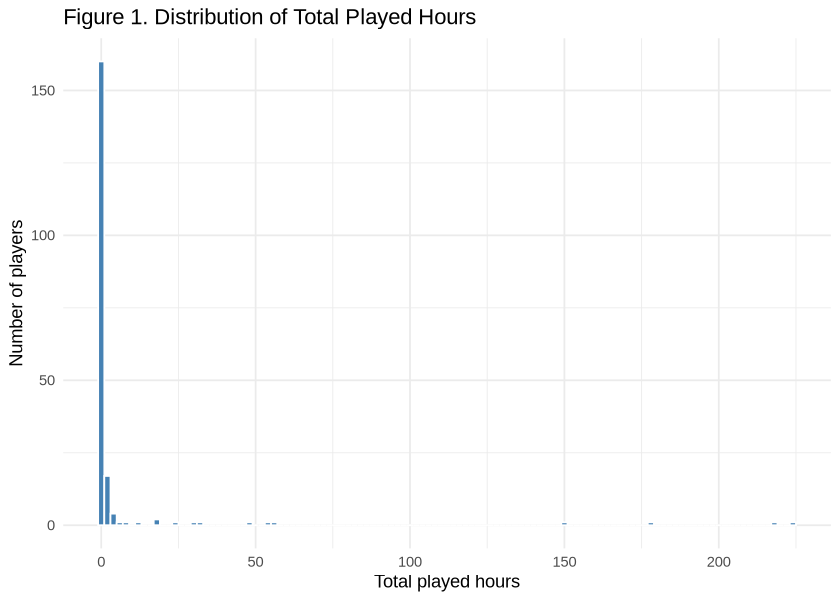

In [8]:
options(repr.plot.width = 7, repr.plot.height = 5)

ggplot(players_full, aes(x = played_hours)) +
  geom_histogram(binwidth = 2, fill = "steelblue", color = "white") +
  labs(
    title = "Figure 1. Distribution of Total Played Hours",
    x = "Total played hours",
    y = "Number of players"
  ) +
  theme_minimal()


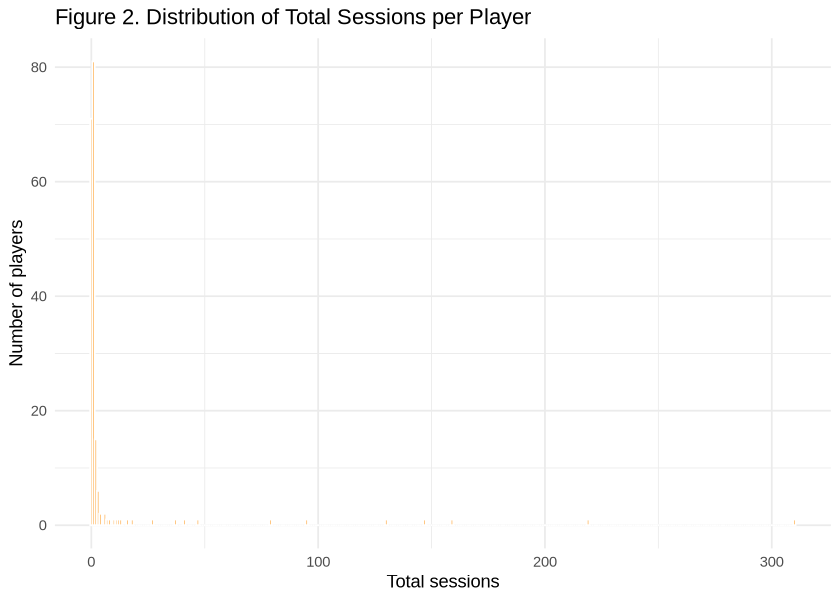

In [9]:
ggplot(players_full, aes(x = total_sessions)) +
  geom_histogram(binwidth = 1, fill = "darkorange", color = "white") +
  labs(
    title = "Figure 2. Distribution of Total Sessions per Player",
    x = "Total sessions",
    y = "Number of players"
  ) +
  theme_minimal()

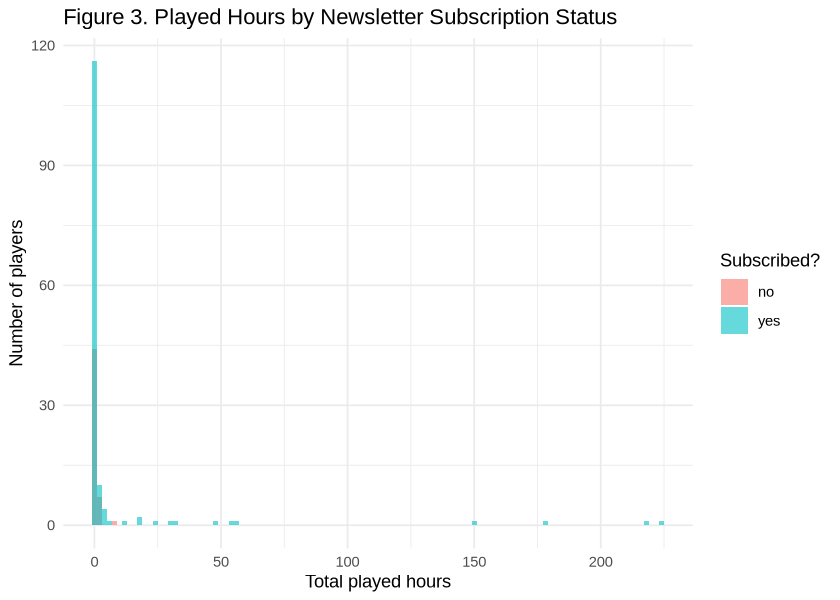

In [10]:
options(repr.plot.width = 7, repr.plot.height = 5)

ggplot(players_full, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(binwidth = 2, position = "identity", alpha = 0.6) +
  labs(
    title = "Figure 3. Played Hours by Newsletter Subscription Status",
    x = "Total played hours",
    y = "Number of players",
    fill = "Subscribed?"
  ) +
  theme_minimal()

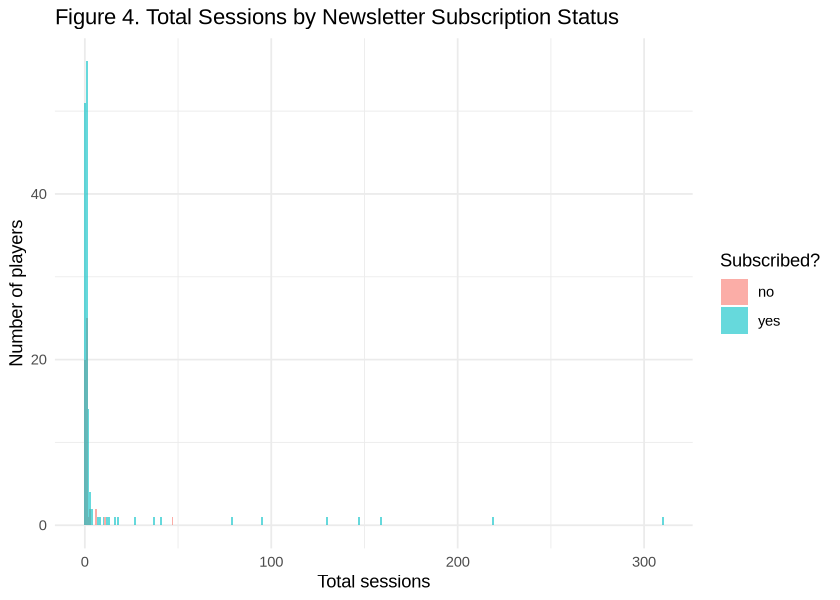

In [11]:
ggplot(players_full, aes(x = total_sessions, fill = subscribe)) +
  geom_histogram(binwidth = 1, position = "identity", alpha = 0.6) +
  labs(
    title = "Figure 4. Total Sessions by Newsletter Subscription Status",
    x = "Total sessions",
    y = "Number of players",
    fill = "Subscribed?"
  ) +
  theme_minimal()

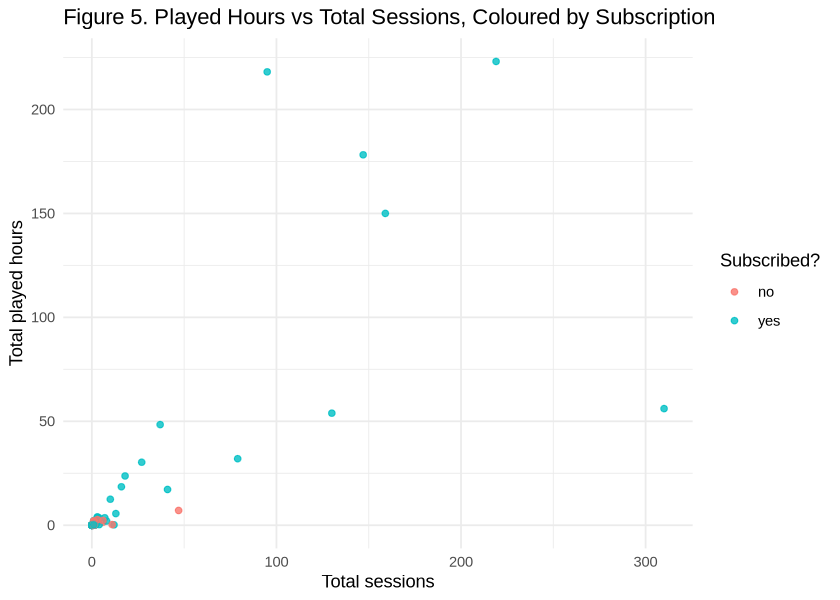

In [12]:
options(repr.plot.width = 7, repr.plot.height = 5)

ggplot(players_full, aes(x = total_sessions, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.8) +
  labs(
    title = "Figure 5. Played Hours vs Total Sessions, Coloured by Subscription",
    x = "Total sessions",
    y = "Total played hours",
    color = "Subscribed?"
  ) +
  theme_minimal()

## Methods & Results

Before we could answer our question, we must better understand the data we are working with. As such, we first glanced at the data using the head() and summarize function to show values summarizing each variable. Then, we needed to wrangle the data so that it was in a workable format. To do this, we grouped each playtime observation in the sessions dataset by player using each player's unique hashed email values, combined the two datasets, then mutated a new total sessions column showing the total number of sessions each player has on the server. The subscribe variable was changed into a factor to allow for classification. With the data now wrangled, we used more visualizations to understand the predictors we are working with; total number of sessions and play time. To visualize the distribution of total number of sessions and play time, we created a histogram showing both (Figures 1 and 2), as well as two further histograms showing their relationship to subscription status (Figures 3 and 4). Finally, we created a scatterplot plotting the relationship between number of sessions and play time, using colours to further note correlations with subscriptions (Figure 5). 

To answer this question, we decided to run a k-Nearest Neighbours (knn) classification model, using total played hours and number of sessions as predictors. This model was deemed optimal for this project as we are predicting subscription rates using observations from two other variables, which best fits the use case of this classification model. To find the most accurate classification model for the dataset, we decided to run 3 consecutive models each using different combinations of our two chosen predictor variables. As such, there will be one model run exclusively using total played hours as the predictor, another model exclusively using number of sessions, and a final model using both. Once we had a better understanding of the data we are working with through exploratory analysis, we first split the data into training and testing sets, following an 80:20 ratio. To make sure our training and testing datasets had similar distributions of subscription rates, we calculated the proportion of players subscribed to players unsubscribed, which turned out to be similar. Next, we created our knn classification with the scaled values of total played hours as the sole predictor, setting up 10-fold cross validation for every alternative value of K between 1 and 51. We fit the model through the training data then collected the accuracies to find the best K values, which turned out to be 51. The accuracy metrics were then shown through a line graph with a point denoting every tested K value (Figure 6) to confirm that this K value was correctly identified as having the highest accuracy in predictions, which it did. Following this step, we tested the model against the test data using K = 51, collecting the accuracy metrics, which was also displayed using a confusion matrix. Using this model with only total played hours as the predictor yielded an accuracy value of 0.675. These steps of creating the model, scaling the predictors, finding the best K value, using it for the testing set, then collecting metrics and creating confusion matrices explained above was repeated for the remaining 2 models. These steps yielded models with accuracy values of 0.725 (only number of sessions) and 0.725 (both predictors) respectively. To make comparison of accuracy values easier between models, a new table with all 3 accuracy values was created, which also shows which value of K resulted in those values. This table was then graphed to provide a more visual approach to identifying which model is the most accurate in predicting subscriptions rates (Figure 9). 

In [13]:
set.seed(1234)

players_split <- initial_split(players_full, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

players_train |> count(subscribe) |> mutate(prop = n / sum(n))
players_test  |> count(subscribe) |> mutate(prop = n / sum(n))


subscribe,n,prop
<fct>,<int>,<dbl>
no,41,0.2628205
yes,115,0.7371795


subscribe,n,prop
<fct>,<int>,<dbl>
no,11,0.275
yes,29,0.725


In [14]:
knn_spec <- nearest_neighbor(
  neighbors  = tune(),
  weight_func = "rectangular"
) |>
  set_engine("kknn") |>
  set_mode("classification")

set.seed(1234)
players_folds <- vfold_cv(players_train, v = 10, strata = subscribe)

k_grid <- tibble(neighbors = seq(1, 51, by = 2))

In [15]:
rec_hours <- recipe(subscribe ~ played_hours, data = players_train) |>
  step_normalize(all_predictors())

set.seed(1234)
res_hours <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(rec_hours) |>
  tune_grid(
    resamples = players_folds,
    grid      = k_grid
  ) |>
  collect_metrics()

hours_acc <- res_hours |>
  filter(.metric == "accuracy")

best_k_hours <- hours_acc |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

best_k_hours


[1] 51

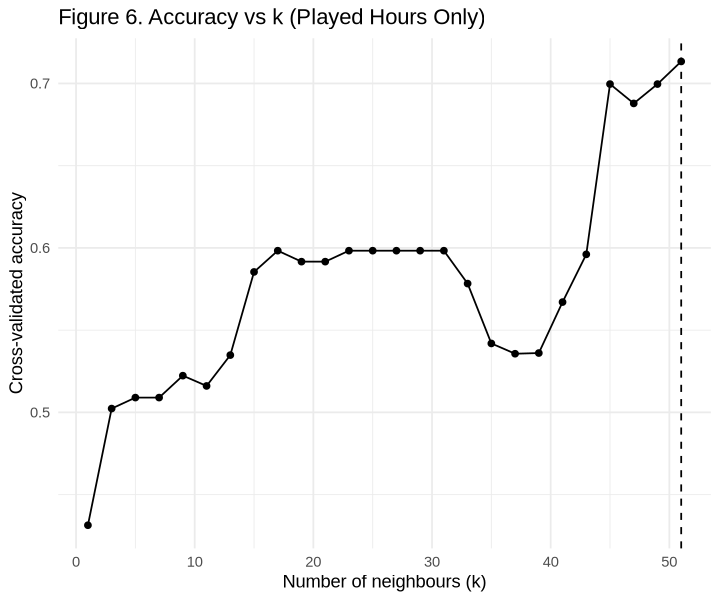

In [16]:
options(repr.plot.width = 6, repr.plot.height = 5)

plot_hours <- ggplot(hours_acc, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = best_k_hours, linetype = "dashed") +
  labs(
    title = "Figure 6. Accuracy vs k (Played Hours Only)",
    x = "Number of neighbours (k)",
    y = "Cross-validated accuracy"
  ) +
  theme_minimal()

plot_hours

In [17]:
best_knn_hours <- knn_spec |>
  finalize_model(tibble(neighbors = best_k_hours))

wf_hours <- workflow() |>
  add_recipe(rec_hours) |>
  add_model(best_knn_hours)

fit_hours <- wf_hours |>
  fit(data = players_train)

pred_hours <- predict(fit_hours, players_test) |>
  bind_cols(players_test)

metrics_hours <- pred_hours |>
  metrics(truth = subscribe, estimate = .pred_class)

cm_hours <- pred_hours |>
  conf_mat(truth = subscribe, estimate = .pred_class)

metrics_hours
cm_hours


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.675000
kap,binary,0.109589


          Truth
Prediction no yes
       no   3   5
       yes  8  24

In [18]:
rec_sessions <- recipe(subscribe ~ total_sessions, data = players_train) |>
  step_normalize(all_predictors())

set.seed(1234)
res_sessions <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(rec_sessions) |>
  tune_grid(
    resamples = players_folds,
    grid      = k_grid
  ) |>
  collect_metrics()

sessions_acc <- res_sessions |>
  filter(.metric == "accuracy")

best_k_sessions <- sessions_acc |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

best_k_sessions


[1] 37

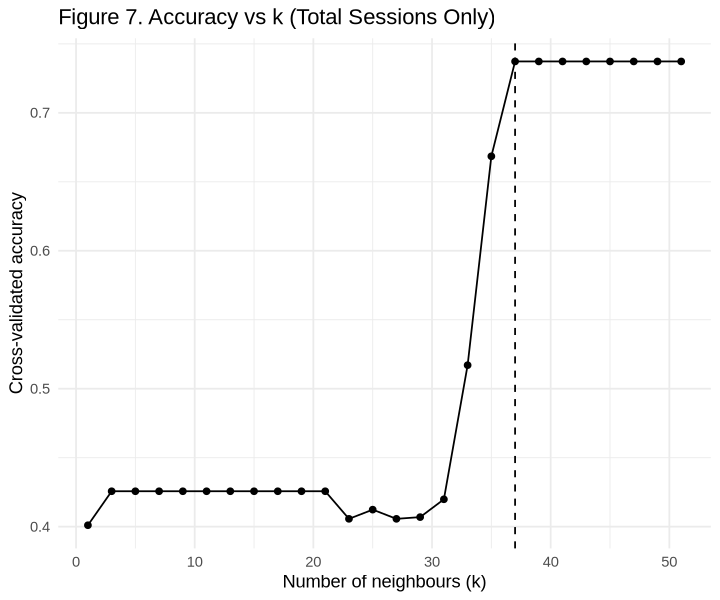

In [19]:
options(repr.plot.width = 6, repr.plot.height = 5)

plot_sessions <- ggplot(sessions_acc, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = best_k_sessions, linetype = "dashed") +
  labs(
    title = "Figure 7. Accuracy vs k (Total Sessions Only)",
    x = "Number of neighbours (k)",
    y = "Cross-validated accuracy"
  ) +
  theme_minimal()

plot_sessions


In [20]:
best_knn_sessions <- knn_spec |>
  finalize_model(tibble(neighbors = best_k_sessions))

wf_sessions <- workflow() |>
  add_recipe(rec_sessions) |>
  add_model(best_knn_sessions)

fit_sessions <- wf_sessions |>
  fit(data = players_train)

pred_sessions <- predict(fit_sessions, players_test) |>
  bind_cols(players_test)

metrics_sessions <- pred_sessions |>
  metrics(truth = subscribe, estimate = .pred_class)

cm_sessions <- pred_sessions |>
  conf_mat(truth = subscribe, estimate = .pred_class)

metrics_sessions
cm_sessions


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725
kap,binary,0.000


          Truth
Prediction no yes
       no   0   0
       yes 11  29

In [21]:
rec_both <- recipe(subscribe ~ played_hours + total_sessions, data = players_train) |>
  step_normalize(all_predictors())

set.seed(1234)
res_both <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(rec_both) |>
  tune_grid(
    resamples = players_folds,
    grid      = k_grid
  ) |>
  collect_metrics()

both_acc <- res_both |>
  filter(.metric == "accuracy")

best_k_both <- both_acc |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

best_k_both


[1] 37

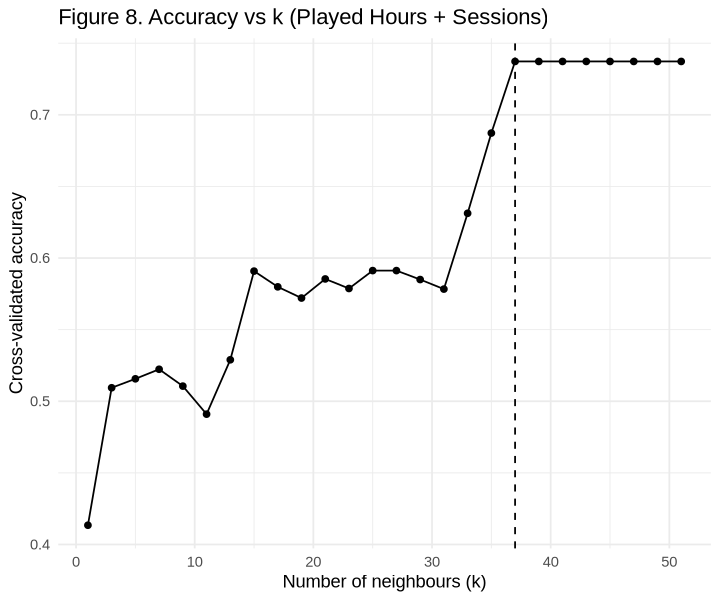

In [22]:
options(repr.plot.width = 6, repr.plot.height = 5)

plot_both <- ggplot(both_acc, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = best_k_both, linetype = "dashed") +
  labs(
    title = "Figure 8. Accuracy vs k (Played Hours + Sessions)",
    x = "Number of neighbours (k)",
    y = "Cross-validated accuracy"
  ) +
  theme_minimal()

plot_both


In [23]:
best_knn_both <- knn_spec |>
  finalize_model(tibble(neighbors = best_k_both))

wf_both <- workflow() |>
  add_recipe(rec_both) |>
  add_model(best_knn_both)

fit_both <- wf_both |>
  fit(data = players_train)

pred_both <- predict(fit_both, players_test) |>
  bind_cols(players_test)

metrics_both <- pred_both |>
  metrics(truth = subscribe, estimate = .pred_class)

cm_both <- pred_both |>
  conf_mat(truth = subscribe, estimate = .pred_class)

metrics_both
cm_both


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725
kap,binary,0.000


          Truth
Prediction no yes
       no   0   0
       yes 11  29

In [24]:
model_comparison <- tibble(
  model      = c("played_hours only", "total_sessions only", "both predictors"),
  best_k     = c(best_k_hours, best_k_sessions, best_k_both),
  accuracy   = c(
    metrics_hours  |> filter(.metric == "accuracy")   |> pull(.estimate),
    metrics_sessions |> filter(.metric == "accuracy") |> pull(.estimate),
    metrics_both   |> filter(.metric == "accuracy")   |> pull(.estimate)
  )
)

model_comparison


model,best_k,accuracy
<chr>,<dbl>,<dbl>
played_hours only,51,0.675
total_sessions only,37,0.725
both predictors,37,0.725


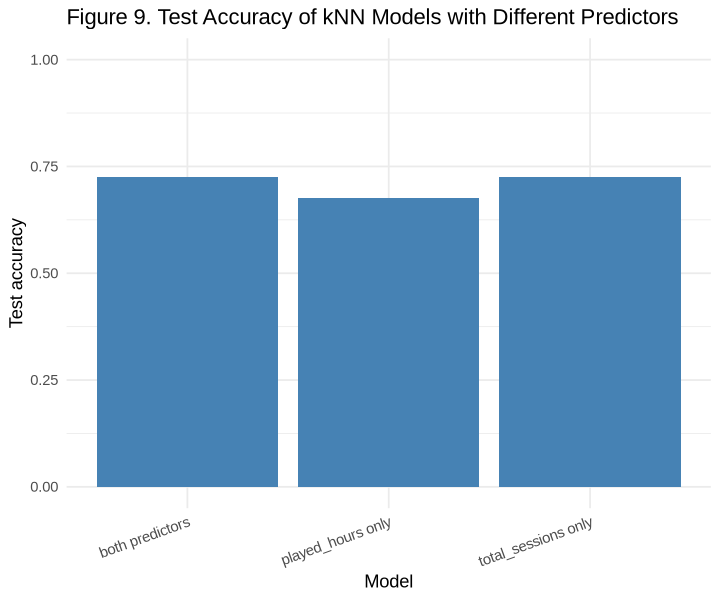

In [25]:
ggplot(model_comparison, aes(x = model, y = accuracy)) +
  geom_col(fill = "steelblue") +
  coord_cartesian(ylim = c(0, 1)) +
  labs(
    title = "Figure 9. Test Accuracy of kNN Models with Different Predictors",
    x = "Model",
    y = "Test accuracy"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1))


## Discussion

Through this project, we have found that total session number is the most effective predictor, as it had the highest accuracy at 0.725 compared to played hours only model which had the lowest accuracy at 0.675. Using both predictors in a model did not result in improvement in predictive performance compared to total sessions only, having the same accuracy of 0.725. The data indicates that the frequency of return sessions is a stronger indicator for the intentional commitment required for a subscription rather than raw play time. 

This difference in accuracy between total session number and play time was expected, as the number of times a player has revisited the server is a better indication of the players continued committment to the server and therefore the newsletter, compared to play time, which can be skewed due to players with one long single session or afk players. Because the decision to subscribe is an intentional, long-term commitment, and a player who demonstrates this type of repeated session logging is logically a better candidate for a subscription than one with high accumulated time from infrequent sessions of playtime. When viewing entire project overall, both predictors performed about as expected, being a good, but not great, predictor for newsletter subscription. This is visible in figure 3, 4, and 5, where it is clear that most, if not all of the players who had a high session count or play time were subscribed to the newsletter, but got a bit more complicated when looking at the trend of players with a low session count or play time, with no clearly visible trend. 

These findings would allow the researchers to focus more on the number of play sessions a player has compared to play time when they are trying to answer their question of "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter?". This could include researchers focusing their newsletter advertisements to frequent players, which can be combined with providing in game rewards/achievements for repeated visits of a certain length compared to setting play time as the milestone to increase subscription to newsletters. 

To further investigate the exploration in this project, one could focus on the player types aspect of the researchers question. Since we already discovered that total session count is the better predictor for subscription rates, a further study could look at how this might change depending on the players age, gender, or experience level, and compare results. This would allow the researchers to predict whether to focus on session number of play time for new incoming players after they fill out the survey, and develop individualized advertisement schedules for each type of player, such as advertising every hour of play time or advertising after every new session. Another future investigation that could lead from this project is looking at average play time per session, developing a similar knn model and seeing if that could better predict subscription rates compared to the two predictors investigated here. 

## GitHub Repository

Our GitHub project repository:

**<https://github.com/daniel-zouli/Dsci-100-Final-Project-Report.git>**